In [3]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, mean_squared_log_error
import tqdm, sys, os, gc, argparse, warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [22]:
# 读取数据
path = './data/'

train_files = os.listdir(path+'train')
train_df = pd.DataFrame()
for filename in tqdm.tqdm(train_files):
    tmp = pd.read_csv(path+'train/'+filename)
    tmp['file'] = filename
    train_df = pd.concat([train_df, tmp], axis=0, ignore_index=True)

test_files = os.listdir(path+'test')
test_df = pd.DataFrame()
for filename in tqdm.tqdm(test_files):
    tmp = pd.read_csv(path+'test/'+filename)
    tmp['file'] = filename
    test_df = pd.concat([test_df, tmp], axis=0, ignore_index=True)

100%|██████████| 296/296 [00:08<00:00, 33.66it/s]


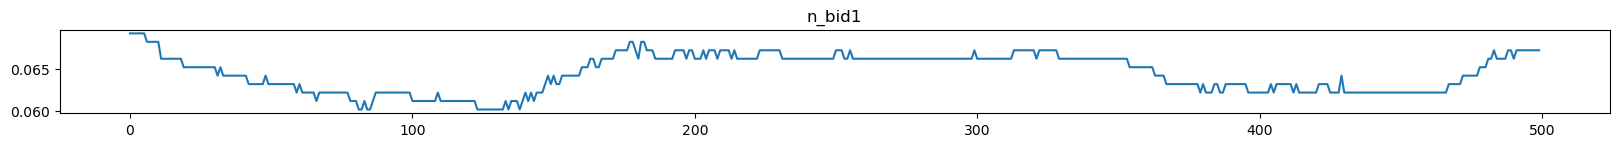

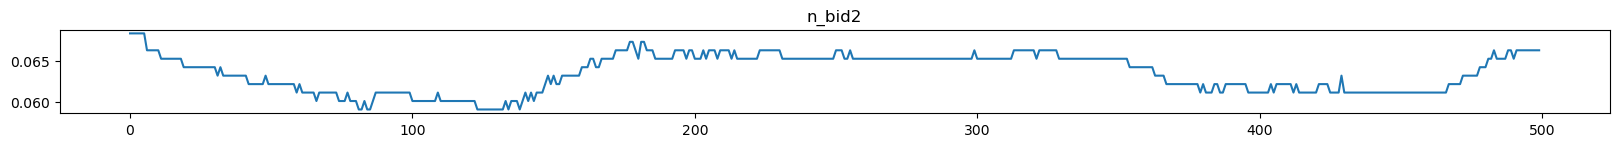

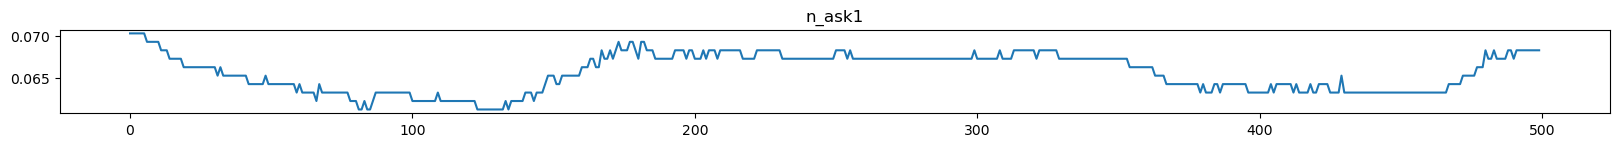

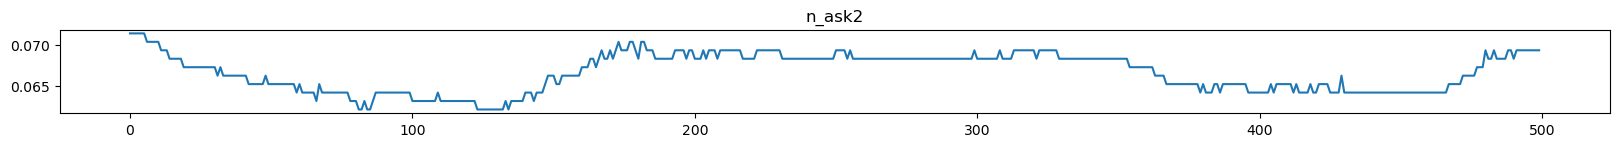

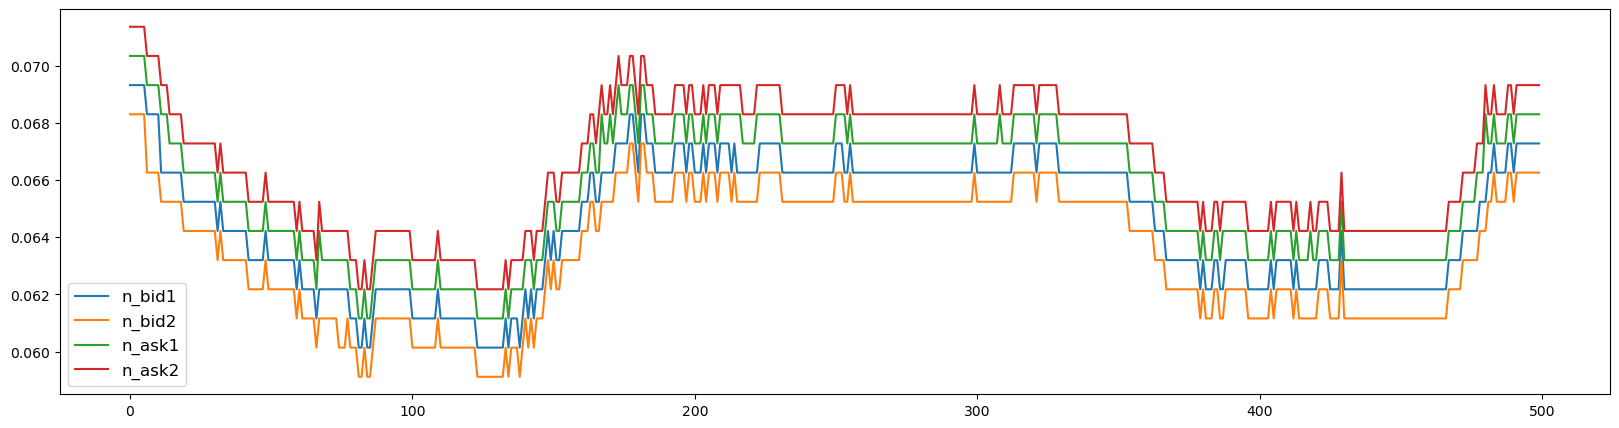

In [23]:
cols = ['n_bid1','n_bid2','n_ask1','n_ask2']
tmp_df = train_df[train_df['file']=='snapshot_sym7_date22_pm.csv'].reset_index(drop=True)[-500:]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
for num, col in enumerate(cols):
    plt.figure(figsize=(20,5))
   
    plt.subplot(4,1,num+1)
    plt.plot(tmp_df['index'],tmp_df[col])
    plt.title(col)
plt.show()
plt.figure(figsize=(20,5))

for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)
plt.legend(fontsize=12)

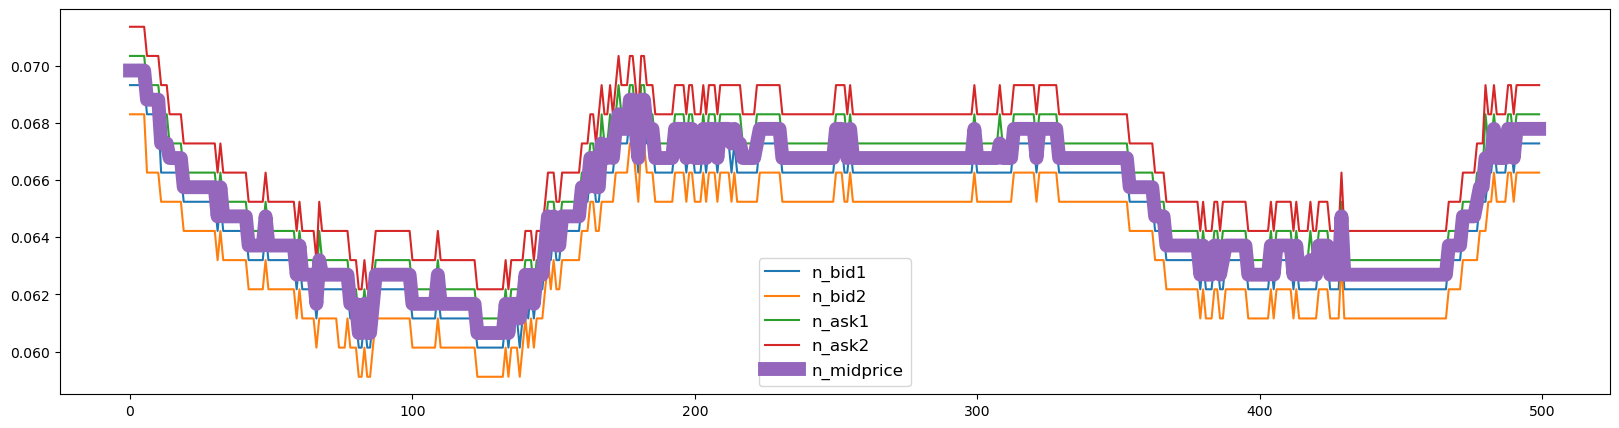

In [24]:
plt.figure(figsize=(20,5))

for num, col in enumerate(cols):
    
    plt.plot(tmp_df['index'],tmp_df[col],label=col)
    
plt.plot(tmp_df['index'],tmp_df['n_midprice'],label="n_midprice",lw=10)
plt.legend(fontsize=12)

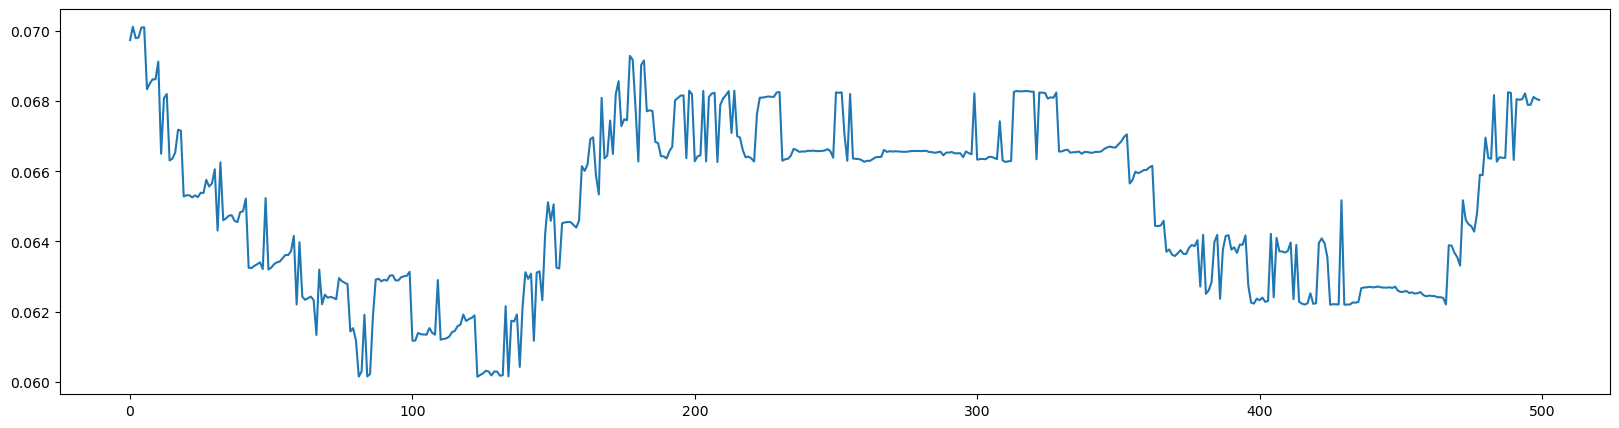

In [25]:
train_df['wap1'] = (train_df['n_bid1']*train_df['n_bsize1'] + train_df['n_ask1']*train_df['n_asize1'])/(train_df['n_bsize1'] + train_df['n_asize1'])
test_df['wap1'] = (test_df['n_bid1']*test_df['n_bsize1'] + test_df['n_ask1']*test_df['n_asize1'])/(test_df['n_bsize1'] + test_df['n_asize1'])

tmp_df = train_df[train_df['file']=='snapshot_sym7_date22_pm.csv'].reset_index(drop=True)[-500:]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
plt.figure(figsize=(20,5))
plt.plot(tmp_df['index'], tmp_df['wap1'])

In [26]:
  # 时间相关特征
train_df['hour'] = train_df['time'].apply(lambda x:int(x.split(':')[0]))
test_df['hour'] = test_df['time'].apply(lambda x:int(x.split(':')[0]))

train_df['minute'] = train_df['time'].apply(lambda x:int(x.split(':')[1]))
test_df['minute'] = test_df['time'].apply(lambda x:int(x.split(':')[1]))

# 入模特征
cols = [f for f in test_df.columns if f not in ['uuid','time','file']]

In [27]:
train_df[cols]


,date,sym,n_close,amount_delta,n_midprice,n_bid1,n_bsize1,n_bid2,n_bsize2,n_bid3,...,n_asize2,n_ask3,n_asize3,n_ask4,n_asize4,n_ask5,n_asize5,wap1,hour,minute
0,0,0,0.015691,2594895.0,0.015270,0.01513,1.961524e-06,0.014850,9.973850e-07,0.014570,...,3.457601e-06,0.015971,0.000010,0.016251,0.000005,0.016531,0.000016,0.015164,9,40
1,0,0,0.015410,837314.0,0.015410,0.01513,3.424355e-06,0.014850,1.030631e-06,0.014570,...,1.057228e-05,0.016251,0.000005,0.016531,0.000016,0.016811,0.000018,0.015388,9,40
2,0,0,0.015130,184807.0,0.015270,0.01513,3.158386e-06,0.014850,9.807620e-07,0.014570,...,6.217033e-06,0.015971,0.000011,0.016251,0.000005,0.016531,0.000017,0.015175,9,40
3,0,0,0.015691,500046.0,0.015551,0.01541,4.155771e-07,0.015130,2.044639e-06,0.014850,...,1.083825e-05,0.016251,0.000005,0.016531,0.000016,0.016811,0.000018,0.015687,9,40
4,0,0,0.014290,1785635.0,0.014710,0.01429,9.308927e-06,0.014010,4.986925e-08,0.013729,...,1.412962e-06,0.015691,0.000036,0.015971,0.000009,0.016251,0.000005,0.014510,9,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2448770,9,9,0.026085,680336.0,0.025998,0.02591,1.153103e-06,0.025735,3.391640e-07,0.025560,...,9.135547e-07,0.026436,0.000003,0.026611,0.000004,0.026786,0.000005,0.026028,14,49
2448771,9,9,0.026085,123081.0,0.025998,0.02591,9.944617e-07,0.025735,3.336936e-07,0.025560,...,8.807324e-07,0.026436,0.000003,0.026611,0.000004,0.026786,0.000005,0.026053,14,49
2448772,9,9,0.025910,409963.0,0.025998,0.02591,9.236202e-07,0.025735,6.072130e-07,0.025560,...,8.752620e-07,0.026436,0.000003,0.026611,0.000004,0.026786,0.000005,0.026054,14,49
2448773,9,9,0.025910,52742.0,0.025998,0.02591,9.017386e-07,0.025735,7.275615e-07,0.025560,...,7.494431e-07,0.026436,0.000003,0.026611,0.000004,0.026786,0.000005,0.026054,14,49


In [28]:
def cv_model(clf, train_x, train_y, test_x, clf_name, seed = 2023):
    folds = 5
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    oof = np.zeros([train_x.shape[0], 3])
    test_predict = np.zeros([test_x.shape[0], 3])
    cv_scores = []
    
    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]
       
        if clf_name == "cat":
            params = {'learning_rate': 0.15, 'depth': 6, 'bootstrap_type':'Bernoulli','random_seed':2023,
                      'od_type': 'Iter', 'od_wait': 1000, 'random_seed': 11, 'allow_writing_files': False,
                      'loss_function': 'MultiClass'}
            
            model = clf(iterations=1000, task_type="GPU", **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      metric_period=20,
                      use_best_model=True, 
                      cat_features=[],
                      verbose=1)
            
            val_pred  = model.predict_proba(val_x)
            test_pred = model.predict_proba(test_x)
        
        oof[valid_index] = val_pred
        test_predict += test_pred / kf.n_splits
        
        F1_score = f1_score(val_y, np.argmax(val_pred, axis=1), average='macro')
        cv_scores.append(F1_score)
        print(cv_scores)
        
    return oof, test_predict
    
train_df_result = pd.DataFrame()
test_df_result = pd.DataFrame()
for label in ['label_5','label_10','label_20','label_40','label_60']:
    print(f'=================== {label} ===================')
    cat_oof, cat_test = cv_model(CatBoostClassifier, train_df[cols], train_df[label], test_df[cols], 'cat')
    train_df_result[label] = np.argmax(cat_oof, axis=1)
    test_df_result[label] = np.argmax(cat_test, axis=1)

=================== label_5 ===================
************************************ 1 ************************************
0:	learn: 0.9932210	test: 0.9932577	best: 0.9932577 (0)	total: 18.6ms	remaining: 18.6s
20:	learn: 0.6909806	test: 0.6910633	best: 0.6910633 (20)	total: 370ms	remaining: 17.2s
40:	learn: 0.6698699	test: 0.6698650	best: 0.6698650 (40)	total: 731ms	remaining: 17.1s
60:	learn: 0.6619231	test: 0.6620255	best: 0.6620255 (60)	total: 1.12s	remaining: 17.3s
80:	learn: 0.6571700	test: 0.6573382	best: 0.6573382 (80)	total: 1.48s	remaining: 16.8s
100:	learn: 0.6540712	test: 0.6543057	best: 0.6543057 (100)	total: 1.86s	remaining: 16.6s
120:	learn: 0.6517853	test: 0.6521859	best: 0.6521859 (120)	total: 2.23s	remaining: 16.2s
140:	learn: 0.6497814	test: 0.6502656	best: 0.6502656 (140)	total: 2.6s	remaining: 15.8s
160:	learn: 0.6481882	test: 0.6488441	best: 0.6488441 (160)	total: 2.98s	remaining: 15.5s
180:	learn: 0.6467928	test: 0.6476399	best: 0.6476399 (180)	total: 3.37s	remai

In [42]:
import copy
test_df_csv = pd.DataFrame()
train_df_csv = copy.deepcopy(train_df)
test_df_csv = copy.deepcopy(test_df)
for label in ['label_5','label_10','label_20','label_40','label_60']:
    test_df_csv[label] = test_df_result[label]
# 指定输出文件夹路径
output_dir = './baseline/submit'

# 如果文件夹不存在则创建
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 首先按照'file'字段对 dataframe 进行分组
grouped = test_df_csv.groupby('file')

# 对于每一个group进行处理
for file_name, group in grouped:
    # 选择你所需要的列
    selected_cols = group[['uuid', 'label_5', 'label_10', 'label_20', 'label_40', 'label_60']]
    
    # 将其保存为csv文件，file_name作为文件名
    selected_cols.to_csv(os.path.join(output_dir, f'{file_name}'), index=False)

In [30]:
# id(train_df)

2787911127280

In [39]:
# import copy
# train_df_csv = pd.DataFrame()
# test_df_csv = pd.DataFrame()
# train_df_csv = copy.deepcopy(train_df)
# test_df_csv = copy.deepcopy(test_df)
# for label in ['label_5','label_10','label_20','label_40','label_60']:
#     test_df_csv[label] = test_df_result[label]

,uuid,date,time,sym,n_close,amount_delta,n_midprice,n_bid1,n_bsize1,n_bid2,...,n_ask3,n_asize3,n_ask4,n_asize4,n_ask5,n_asize5,file,wap1,hour,minute
0,0,64,09:40:03,0,0.075679,6954413.0,0.075775,0.075679,2.161001e-06,0.075486,...,0.076256,7.812850e-07,0.076449,2.992155e-06,0.076642,1.662308e-08,snapshot_sym0_date64_am.csv,0.075777,9,40
1,1,64,09:40:06,0,0.076256,13722908.0,0.076160,0.076064,1.393014e-05,0.075871,...,0.077027,4.322002e-07,0.077219,2.825924e-07,0.077412,7.646619e-07,snapshot_sym0_date64_am.csv,0.076065,9,40
2,2,64,09:40:09,0,0.077027,21771348.0,0.077123,0.077027,2.456892e-05,0.076834,...,0.077604,1.329847e-07,0.077797,2.161001e-07,0.077990,3.042024e-06,snapshot_sym0_date64_am.csv,0.077028,9,40
3,3,64,09:40:12,0,0.077027,2925847.0,0.077508,0.077027,2.091184e-05,0.076834,...,0.078375,1.612273e-04,0.078567,8.311542e-07,0.078760,4.488233e-07,snapshot_sym0_date64_am.csv,0.077135,9,40
4,4,64,09:40:15,0,0.078375,9831626.0,0.078182,0.077990,2.626447e-06,0.077797,...,0.078760,4.488233e-07,0.078952,2.659693e-07,0.079145,3.490848e-07,snapshot_sym0_date64_am.csv,0.078368,9,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591699,1994,78,14:49:45,9,-0.001504,2305964.0,-0.001562,-0.001620,1.455123e-06,-0.001736,...,-0.001157,5.525091e-07,-0.001041,5.032756e-07,-0.000926,2.297563e-06,snapshot_sym9_date78_pm.csv,-0.001534,14,49
591700,1995,78,14:49:48,9,-0.001620,3132273.0,-0.001678,-0.001736,8.971435e-07,-0.001851,...,-0.001388,3.282232e-08,-0.001273,1.039374e-07,-0.001157,5.525091e-07,snapshot_sym9_date78_pm.csv,-0.001639,14,49
591701,1996,78,14:49:51,9,-0.001736,2364061.0,-0.001793,-0.001851,7.601650e-07,-0.001967,...,-0.001504,4.575268e-06,-0.001388,3.282232e-08,-0.001273,1.641116e-07,snapshot_sym9_date78_pm.csv,-0.001818,14,49
591702,1997,78,14:49:54,9,-0.001851,20587972.0,-0.002256,-0.002661,3.260351e-08,-0.002777,...,-0.001620,5.962722e-06,-0.001504,4.569797e-06,-0.001388,3.282232e-08,snapshot_sym9_date78_pm.csv,-0.001860,14,49
